# Parameters needed for simulation 1

### model parameters

**R₀**: the total number of people an infected person infects (R₀ = β / γ)

**k**: constant for unit 1000 used for population

**gamma (γ)**: the proportion of infected recovering per day (γ = 1/D).

**β**: expected amount of people an infected person infects per day.  β = R₀ * γ

**tf**: not sure what this is. Might be duration of simulation

**contact_matrix**: three by three contact matrix. fill(1/3,3,3)

**Nyoung**: number of people in young bracket

**Nmiddle**: number of people in middle bracket

**Nold**: number of people in old bracket

**three_age_groups**: the age brackets as an array. ([Nyoung,Nmiddle,Nold])

**numinfected**: number of infected individuals in each state

**infectedfrac**: specifies the fraction of each group that should be considered infected initially.


### Contact Matrix from real data

these parameters are interesting and valuable pieces of data. We probably want to capture additional information about them, which means we capture more information about parameters in general.

Optional things we might capture:

1. Source

2. year

3. columns rows descriptions

4. min max values in cells.

5. coverage of where the data was collected from

6. real or synthetic data.

If we are able to save enough meta data about the matrix then it can potentially be used for other models/scenarios. If a new flu strain came out in Italy we might be able to use the latest contact matrix for covid in helping model the infections of this new flu.


### Questions
1. What exactly will be provided by TA 3? Is it just the easy modeling library?

In [1]:
using EasyModelAnalysis, LinearAlgebra
using EasyModelAnalysis.ModelingToolkit: toparam
using EasyModelAnalysis.ModelingToolkit.Symbolics: FnType, variable, variables
using XLSX, CSV, DataFrames, Plots
using Catlab, Catlab.CategoricalAlgebra, Catlab.Programs, AlgebraicPetri,
      AlgebraicPetri.TypedPetri
using Base: splat

In [2]:
# globals that are hard coded - these will need to be updated by the user or infered by TA1
# tf is 
tf = 600

# k is a constant unit for 1000. Used for population
const k = 1000

# gamma (γ): the proportion of infected recovering per day (γ = 1/D)
const γ = 1 / 14

#R₀: the total number of people an infected person infects (R₀ = β / γ)
const R₀ = 5

#β: expected amount of people an infected person infects per day
const β = R₀ * γ


matrix=fill(1/3,3,3) # contact matrix
Nyoung=2k # number young
Nmiddle=2k # number middle aged
Nold=2k # number old
three_age_groups=[Nyoung,Nmiddle,Nold] # might just be this as an array
numinfected=1 
infectedfrac=nothing

Scenario Ask: In order to consider more nuanced interventions, we would like for models to account for different age groups and their contact dynamics. Start with a basic SIR model without vital dynamics, and stratify it according to the following questions.

In [3]:
tf = 600
const k = 1000
const γ = 1 / 14
const R₀ = 5
const β = R₀ * γ

"""
    make_stratified_model(pops, contactmat; infectedfrac = nothing)

Given a list of population buckets `pops` (of length `n`), create a stratified SIR model with interaction
incidence given by `contactmat`. The SIR parameters γ and R0 (and thus β) are inherited from global scope.
Returns the system of differential equations that can be used for futher simulations.

The optional keyword argument `infectedfrac` specifies the fraction of each group that should be
considered infected initially.
"""
function make_stratified_model(pops, contactmat; infectedfrac = nothing)
    types = LabelledPetriNet([:Pop],
                             :infect => ((:Pop, :Pop) => (:Pop, :Pop)),
                             :disease => (:Pop => :Pop),
                             :strata => (:Pop => :Pop))
    sir_uwd = @relation () where {(S::Pop, I::Pop, R::Pop)} begin
        infect(S, I, I, I)
        disease(I, R)
    end
    sir_typed = oapply_typed(types, sir_uwd, [:inf, :rec])
    totalpop = sum(pops)
    n = length(pops)
    I₀ = something(infectedfrac, n / totalpop)
    sir_paramd = add_params(sir_typed,
                            Dict{Symbol, Float64}(:S => 1 - I₀, :I => I₀, :R => 0),
                            Dict(:inf => β, :rec => γ))

    ages = pairwise_id_typed_petri(types, :Pop, :infect, [Symbol("A$i") for i in 1:n],
                                   pops, contactmat ./ pops,
                                   codom_net = codom(sir_paramd))
    ages = add_reflexives(ages, repeat([[:disease]], n), types)
    return typed_product(sir_paramd, ages)
end

"""
    scenario1(pops, contactmat; infectedfrac, numinfected)

Run a scenario 1 simulation with the given population buckets and contact matrix.
`infectedfrac` has the same meaning as in `make_stratified_model`.
`numinfected` allows specifying a fixed number of individuals in each age group
considered infected initially.
"""
function scenario1(pops, mat; infectedfrac = nothing, numinfected = nothing)
    sir_strat = flatten_labels(make_stratified_model(pops, mat; infectedfrac).dom)
    sys = ODESystem(sir_strat)
    U₀ = map(splat(*), sir_strat[:, :concentration])
    if !isnothing(numinfected)
        U₀[2:2:end] .= numinfected
    end
    P = map(splat(*), sir_strat[:, :rate])
    prob = ODEProblem(sys, U₀, (0, tf), P)
end

scenario1

In [4]:
function LogNormalPrior(mean, variance)
    μ = log(mean^2 / sqrt(mean^2 + variance))
    σ = sqrt(log(1 + variance / mean^2))
    LogNormal(μ, σ)
end

function create_priors(prob, C_mean, var)
    c_priors = []
    params = parameters(prob.f.sys)
    for (i,c) in enumerate(C_mean)
        if C_mean[i] > 0
            push!(c_priors, params[i] => LogNormalPrior(C_mean[i], var))
        else
            push!(c_priors, params[i] => Normal(C_mean[i], 0.0))
        end
    end
    vcat(c_priors, [params[end] => LogNormalPrior(0.07, var)])
end

create_priors (generic function with 1 method)

Start with a simple stratification with three age groups: young, middle-aged, and old.

Begin with a situation where the population size across each age group is uniform: Nyoung = 2k, Nmiddle = 2k, N_old = 2k. Assume only one person in each age group is infectious at the beginning of the simulation. Let gamma = 1/14 days, and let R0 = 5. Assume gamma, beta, and R0 are the same for all age groups.

i. Simulate this model for the case where the 3x3 contact matrix is uniform (all values in matrix are 0.33)



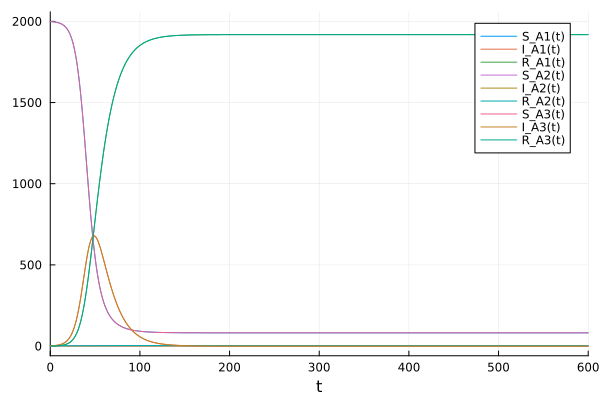

In [5]:
prob = scenario1(three_age_groups, matrix, numinfected = numinfected)
sol = solve(prob)
plt_a1 = plot(sol, leg = :topright)

In [ ]:
# unable to get priors to work

In [6]:
_p = []
for (i,var) in enumerate([0.0001, 0.001, 0.01, 0.1, 1])
    pltkwargs = i == 5 ? (;seriescolor = [:red :green :blue], label = ["Infected Young" "Infected Middle" "Infected Old"]) : (;seriescolor = [:red :green :blue])
    param_priors = create_priors(prob, fill(1 / 3, (3, 3)), var)
    push!(_p, plot_uncertainty_forecast_quantiles(prob, [variable( Symbol("I_A1(t)")), variable( Symbol("I_A2(t)")), variable( Symbol("I_A3(t)"))], 0.0:1:100.0, param_priors, 50; ))
end
plot(_p..., layout = (1, 5), size = (1600, 300), plot_title = "Infected with varying priors", legend = :outerright)



BoundsError: BoundsError: attempt to access 9-element Vector{Float64} at index [1:101]

ii. Simulate this model for the case where there is significant in-group contact preference – you may choose the numbers in the matrix to represent this in- group preference.

In [7]:
contact_matrix = [0.4 0.05 0.1
                  0.05 0.4 0.15
                  0.1 0.15 0.4]

3×3 Matrix{Float64}:
 0.4   0.05  0.1
 0.05  0.4   0.15
 0.1   0.15  0.4

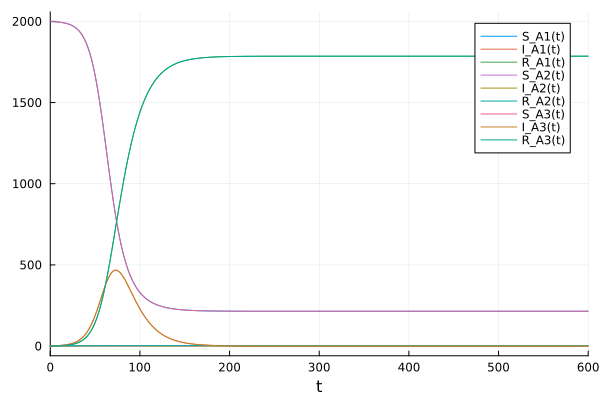

In [8]:
prob = scenario1([2k, 2k, 2k], contact_matrix, numinfected = 1)
sol = solve(prob)
plt_a2 = plot(sol, leg = :topright)

In [ ]:
# unable to get priors to run

In [36]:
_p = []
for (i,var) in enumerate([0.0001, 0.001, 0.01, 0.1, 1])
    pltkwargs = i == 5 ? (;seriescolor = [:red :green :blue], label = ["Infected Young" "Infected Middle" "Infected Old"]) : (;seriescolor = [:red :green :blue])
    param_priors = create_priors(prob, contact_matrix, var)
    push!(_p, plot_uncertainty_forecast_quantiles(prob, [variable( Symbol("I_A1(t)")), variable( Symbol("I_A2(t)")), variable( Symbol("I_A3(t)"))], 0.0:1:100.0, param_priors, 50; pltkwargs...))
end
plot(_p..., layout = (1, 5), size = (1600, 300), plot_title = "Infected with varying priors", legend = :outerright)

LoadError: MethodError: no method matching plot_uncertainty_forecast_quantiles(::ODEProblem{Vector{Float64}, Tuple{Int64, Int64}, true, Vector{Float64}, ODEFunction{true, SciMLBase.AutoSpecialize, ModelingToolkit.var"#f#510"{RuntimeGeneratedFunctions.RuntimeGeneratedFunction{(:ˍ₋arg1, :ˍ₋arg2, :t), ModelingToolkit.var"#_RGF_ModTag", ModelingToolkit.var"#_RGF_ModTag", (0x1b60e2c7, 0xa404afd0, 0x0963fec4, 0x9a06f91d, 0xee6e186d)}, RuntimeGeneratedFunctions.RuntimeGeneratedFunction{(:ˍ₋out, :ˍ₋arg1, :ˍ₋arg2, :t), ModelingToolkit.var"#_RGF_ModTag", ModelingToolkit.var"#_RGF_ModTag", (0x2653713b, 0xca5049a2, 0xb36f6c56, 0x2b20c9a4, 0xe22eca71)}}, UniformScaling{Bool}, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Vector{Symbol}, Symbol, Vector{Symbol}, ModelingToolkit.var"#521#generated_observed#518"{Bool, ODESystem, Dict{Any, Any}}, Nothing, ODESystem}, Base.Pairs{Symbol, Union{}, Tuple{}, NamedTuple{(), Tuple{}}}, SciMLBase.StandardODEProblem}, ::Vector{Num}, ::StepRangeLen{Float64, Base.TwicePrecision{Float64}, Base.TwicePrecision{Float64}, Int64}, ::Vector{Any}, ::Int64; seriescolor=[:red :green :blue])
[0mClosest candidates are:
[0m  plot_uncertainty_forecast_quantiles(::Any, ::Any, ::Any, ::Any, ::Any) at ~/.julia/packages/EasyModelAnalysis/7vQch/src/basics.jl:151[91m got unsupported keyword argument "seriescolor"[39m
[0m  plot_uncertainty_forecast_quantiles(::Any, ::Any, ::Any, ::Any, ::Any, [91m::Any[39m) at ~/.julia/packages/EasyModelAnalysis/7vQch/src/basics.jl:151[91m got unsupported keyword argument "seriescolor"[39m

iii. Simulate this model for the case where there is no contact between age groups. You may choose the numbers in the matrix, but ensure it meets the requirement of no contact between age groups.

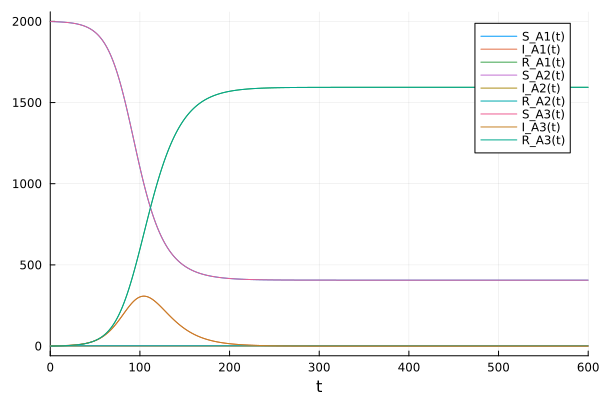

In [9]:
prob = scenario1([2k, 2k, 2k], Diagonal(contact_matrix), numinfected = 1)
sol = solve(prob)
plt_a3 = plot(sol, leg = :topright)

Simulate social distancing by scaling down the uniform contact matrix by a factor (e.g. multiply by 0.5)



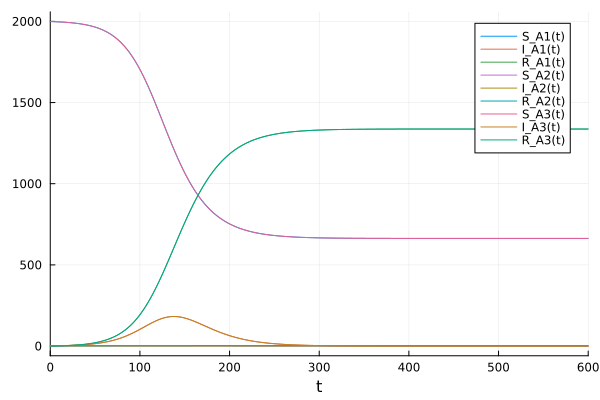

In [10]:
uniform_matrix = fill(0.33, (3, 3))
prob = scenario1([2k, 2k, 2k], 0.5 * uniform_matrix, numinfected = 1)
sol = solve(prob)
plt_a4 = plot(sol, leg = :topright)

Repeat 1.a.iv for the scenario where the young population has poor compliance with social distancing policies, but the old population is very compliant.

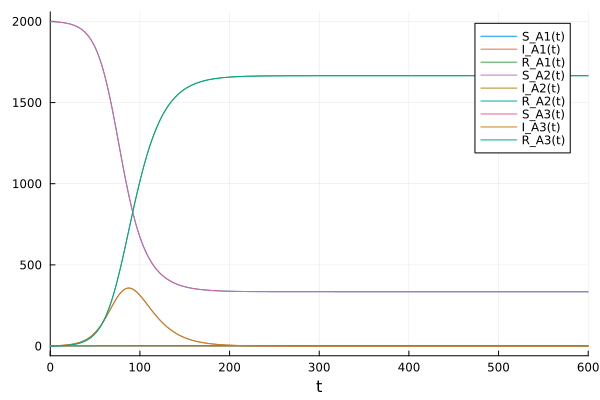

In [11]:
scaling = Diagonal([0.9, 0.8, 0.4])
sol = solve(scenario1([2k, 2k, 2k], scaling * uniform_matrix, numinfected = 1))
plt_a5 = plot(sol, leg = :topright)

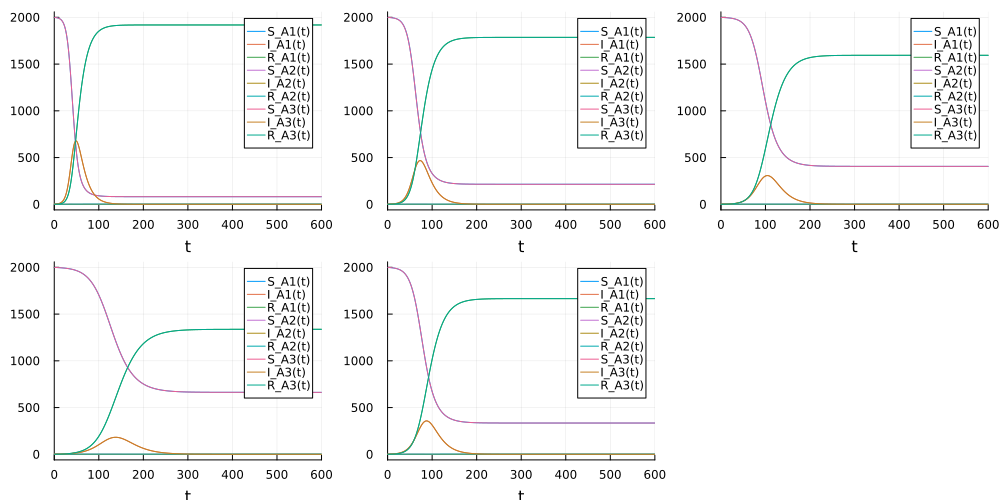

In [12]:
plot(plt_a1, plt_a2, plt_a3, plt_a4, plt_a5, size = (1000, 500))


QUESTION 2
We make no attempt to normalize or otherwise adjust the contact matrices. The interpretation of the contact matrices needs to be consistent with the SIR parameter β, which is fixed in our the given scenario. In a real world case, care would need to be taken to match the units of the contact matrix to the units of β.

In [13]:
xf_all_locations1 = XLSX.readxlsx("data/MUestimates_all_locations_1.xlsx")
xf_all_locations2 = XLSX.readxlsx("data/MUestimates_all_locations_2.xlsx")
xf_work1 = XLSX.readxlsx("data/MUestimates_work_1.xlsx")
xf_work2 = XLSX.readxlsx("data/MUestimates_work_2.xlsx")
xf_school1 = XLSX.readxlsx("data/MUestimates_school_1.xlsx")
xf_school2 = XLSX.readxlsx("data/MUestimates_school_2.xlsx")
xf_home1 = XLSX.readxlsx("data/MUestimates_home_1.xlsx")
xf_home2 = XLSX.readxlsx("data/MUestimates_home_2.xlsx")
xf_other1 = XLSX.readxlsx("data/MUestimates_other_locations_1.xlsx")
xf_other2 = XLSX.readxlsx("data/MUestimates_other_locations_2.xlsx")

xfs1 = (; all = xf_all_locations1, work = xf_work1, school = xf_school1,
        home = xf_home1, other = xf_other1)
xfs2 = (; all = xf_all_locations2, work = xf_work2, school = xf_school2,
        home = xf_home2, other = xf_other2)

to_cm(sheet) = Float64[sheet[i, j] for i in 2:17, j in 1:16]

to_cm (generic function with 1 method)

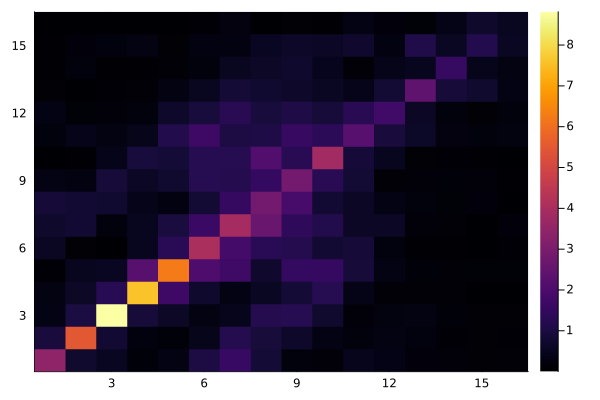

In [14]:
cm_belg = to_cm(xf_all_locations1["Belgium"])
heatmap(cm_belg, yflip = false)

In [15]:
pop_belg = collect(values(CSV.read("data/2022_ Belgium_population_by_age.csv", DataFrame,
                                   header = 3)[1, 2:17]))

LoadError: ArgumentError: "data/2022_ Belgium_population_by_age.csv" is not a valid file